# M2 | Exploration Notebook

In this notebook, you will do a first exploration of the data set that you will use for your project. One part of this exploration is guided, i.e. we will ask you to solve specific questions (task 1-3). The other part is open, i.e. we will ask you to come up with your own exploration ideas (task 4). 

Please upload your solved notebook to Moodle (under Milestone 2 Submission)adding your SCIPER number in title, example: m2-lernnavi-456392.ipynb


## Brief overview of Lernnavi
[Lernnavi](https://www.lernnavi.ch) is an instrument for promoting part of the basic technical study skills in German and mathematics.


For the guided part of the exploration we will focus on the three main tables:
* *users*: demographic information of users.
* *events*: events done by the users in the platform.
* *transactions*: question and answer solved by user.

### Users
* user_id: unique identifier of user in database.
* gender: only three values: M male, F female or missing (star). 
* canton: swiss canton.
* class_level: school year in swiss system.
* study: boolean variable. True if the student participated in the study.
* class_id: identifier of student’s class (only for the students in the experiment)


### Events
* event_id: unique identifier of event in database.
* user_id: user who peformed the event.
* event_date: timestamp of event.
* category: classification of action (task, general, statistics, etc).
* action: type of action performed.
* event_type: whether the students viewed or clicked in the event.
* transaction_token: used to link to transactions table.
* tracking_data: optional content associated to this event (e.g., the new points mastered for a topic).
* session_id: session during which the event took place.
* topic_id: the topics represent the taxonomy of categories shown in the Deutsch and Math dashboard. See topics_translated table.
* session_closed: whether the session has been finished (1: finished; 0: not finished).
* session_type: whether the session is a learn or level check (1: learn; 2: level check).
* session_accepted: whether the user finally accepted the result of the session (1: accepted; 0: refused).

### Transactions
* transaction_id: unique identifier of transaction in database.
* transaction_token: used to link to events table.
* user_id: user who performed the transaction.
* document_id: document that was answered in transaction.
* document_version: version of document that was answered.
* evaluation: whether the user answered correctly or not. It is possible that it was only partially right. 
* input: answer the user gave.
* start_time: timestamp of when the user started answering.
* commit_time: timestamp of when the user submitted the answer.
* user_agent: the browser that the user used.
* solution: solution to question.
* type: type of question that was answered. 
* session_id: session during which the event took place.
* topic_id: the topics represent the taxonomy of categories shown in the Deutsch and Math dashboard. See topics_translated table.
* session_closed: whether the session has been finished (1: finished; 0: not finished).
* session_type: whether the session is a learn or level check (1: learn; 2: level check).
* session_accepted: whether the user finally accepted the result of the session (1: accepted; 0: refused).
* challenge: (boolean) whether the transaction was part of a challenge or not. Professors can create challenges containing different documents
* challenge_id: unique identifier of challenges. The same challenge can be done by multiple students. The pre-test and post-test in the study were designed like challenges.
* challenge_order: within the challenge, the order of the questions. The order matters because sometimes the questions were adapted depending on the student’s knowledge.
* challenge_name: name given to the challenges. 

## Useful Metadata Files
* [Data description](https://docs.google.com/document/d/1NPFNwi79JddrxZM-CpltH5nHro5btHRSNnYcAGj7Y0A/edit?usp=sharing)


In [7]:
# Import the tables of the data set as dataframes.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

DATA_DIR = './../../data/Lernnavi' #You many change the directory

users = pd.read_csv('{}/users.csv.gz'.format(DATA_DIR))
events = pd.read_csv('{}/events.csv.gz'.format(DATA_DIR))
transactions = pd.read_csv('{}/transactions.csv.gz'.format(DATA_DIR))

## Task 1: Simple Statistics

In this task you are asked to do a first coarse exploration of the data set, using simple statistics and visualizations.

#### a) How many distinct participants do we have in the data set?


In [16]:
## Your code goes here


print("Number of distinct participants = ",len(users.user_id.unique()))

Number of distinct participants =  30929


#### b) How many transactions were done per user? Please provide a visualization and discuss the distribution.

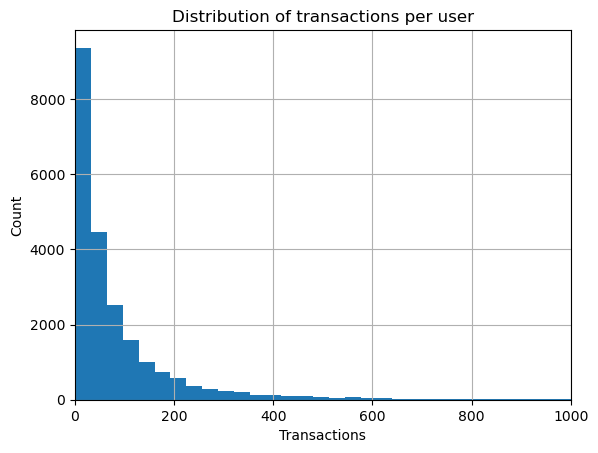

In [45]:
# Your code goes here

transactions_per_user = transactions.groupby("user_id")["transaction_id"].count()
transactions_per_user.hist(bins = 500)

plt.xlim(0,1000)
plt.xlabel("Transactions")
plt.ylabel("Count")
plt.title("Distribution of transactions per user")
plt.show()

*Your discussion/interpretation goes here*


#### c) Which are the 10 most popular event actions? Please provide a visualization of the frequency of the top 10 event actions.

Hint: See actions in table events.

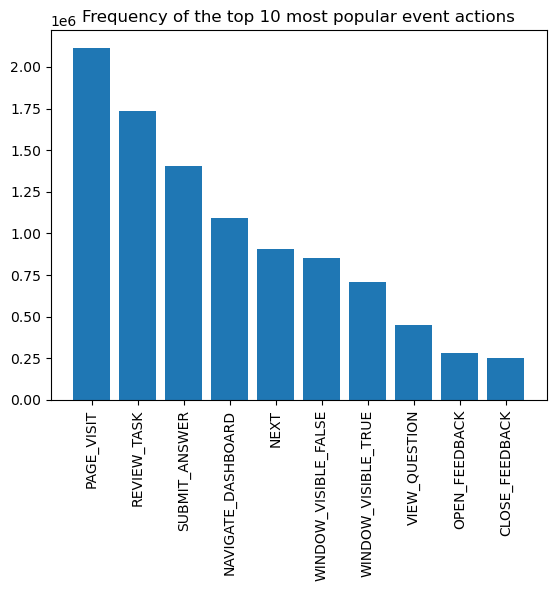

In [63]:
# Your code goes here

top_event_actions = events.groupby(["action"])["event_id"].count().nlargest(10)

plt.bar(top_event_actions.index, top_event_actions.values)
plt.xticks(rotation = 90)
plt.title("Frequency of the top 10 most popular event actions")
plt.show()



PAGE_VISIT: Most popular event action since it is a basic and essential action to perform any sort of activity within the platform. 

REVIEW_TASK : Gets used mutliple times within an excercise suggesting that users either tend to get stuck or are encourage to review their performance before moving onto the next exercise

SUBMIT_ANSWER: Reflects the number of submissiin and attempts made by user, which is a lot. This signfies that the users are completing the exercises

NAV_DASHBOARD: High frequency shows the lateral usage i.e. usage of different elements provided on the platform


## Task 2: Static Analysis

In this second task, you will do a univariate an multivariate exploration of some aggregated features.

#### a) Build a data frame containing one row per user:

``[user_id, gender, num_events, num_questions, percentage_correct, num_reading]``


The features are defined as follows:

- **num_questions**: total number of questions the student answered (hint: action event = submit answer)

- **num_events**: total number of events of the student (hint: in events table)  

- **percentage_correct**: number of correct answers/total number of answers (hint: evaluation = correct). If desired, you may assign a weight of 0.5 to partially correct answers. 

- **num_reading**: total number of theory reading events  (hint: action event = go to theory)

In [87]:
# Your code for building the data frame here
def count_cat1(series):
    return (series == "SUBMIT_ANSWER").sum()
def count_cat2(series):
    return (series == "GO_TO_THEORY").sum()

num_questions = events.groupby("user_id")["action"].apply(count_cat1).reset_index(name='num_question').set_index("user_id")
num_events = events.groupby("user_id")["event_type"].count()
num_reading = events.groupby("user_id")["action"].apply(count_cat2).reset_index(name='num_reading').set_index("user_id")

dict = {"WRONG": 0, "PARTIAL": 0.5, "CORRECT": 1, np.NaN:np.NAN}

transactions["score"] = transactions["evaluation"].apply(lambda x: dict[x])

percentage_correct = transactions.groupby("user_id")["score"].mean()*100

num_reading

,num_reading
user_id,
387604,677
387605,35
387608,58
387613,7
387615,18
...,...
431999,0
432001,0
432014,1


In [89]:
# pd.merge(users, df2, left_index=True, right_index=True)
users

,user_id,gender,canton,class_level,study,class_id
0,387604,NaN,NaN,NaN,False,NaN
1,387605,NaN,NaN,NaN,False,NaN
2,387608,NaN,NaN,NaN,True,9Q2M7
3,387613,NaN,NaN,NaN,False,NaN
4,387615,MALE,SG,Gymnasium - 3. Jahr,False,NaN
...,...,...,...,...,...,...
30924,432018,MALE,SH,Gymnasium - 1. Jahr,False,NaN
30925,432020,MALE,BS,Gymnasium - 2. Jahr,False,NaN
30926,432021,FEMALE,BS,Gymnasium - 1. Jahr,False,NaN
30927,432022,FEMALE,AR,andere,False,NaN


b) Perform a univariate analysis (including descriptive statistics and visualizations) for the five features (gender, num_events, num_questions, percentage_correct, num_reading) of your dataframe. Please check the lecture slides regarding information on how to perform a univariate analysis for categorical and numerical features. Discuss your results: how are the features distributed? Are there any anomalities?

In [ ]:
# Your code for univariate analysis here

*Your discussion/interpretation goes here*

c) Come up with two additional features on your own and add them to the dataframe. Please provide an explanation/description of your features as well as an argument/hypothesis of why you think these features are interesting to explore.

In [ ]:
# Your code for computing the features and adding them to the df goes here

*Your feature descriptions and arguments/hypotheses go here*

d) Perform a univariate analysis of your features (including descriptive statistics and visualization). What can you observe? Do the results confirm your hypotheses?

In [ ]:
# Your code for univariate analysis goes here

*Your discussion/interpretation goes here*

e) Perform a multivariate analysis for two pairs of features of your choice. Please provide a metric and a visualization for both pairs. Please discuss: why did you choose these two pairs? What was your hypothesis? Do the results confirm your hypothesis?

In [ ]:
# Your code for multivariate analysis goes here

*Your discussion/interpretation goes here*

# Task 3: Time-Series Analysis

In the last task, you will perform a time-series analysis.


#### a) Build a data frame containing one row per user per week:

``[user_id, week, num_events, num_questions, percentage_correct, num_reading]``


The features are defined as follows:

- **num_questions**: total number of questions the student answered **per week**(hint: action event = submit answer).

- **num_events**: total number of events of the student per week.

- **percentage_correct**: number of correct answers/total number of answers  **per week** (hint: evaluation = correct). If desired, you may assign a weight of 0.5 to partially correct answers.

- **num_reading**: total number of theory reading events **per week** (hint: action event = go to theory).

Where week 0 is the first week the specific user solved a task in the platform, i.e., the user's earliest entry in the transactions table.

Hint: You may extract the week of the year (dt.week) from the timestamps.

Hint 2: Be mindful that week 1 in 2022 is a different week from week 1 in 2023.

You can limit the number of weeks to 10, i.e. for each user we just look at the first 10 weeks of data.
You may change and justify your choice for the number of weeks.

In [ ]:
# Your code for building the dataframe goes here

#### b) Select two features and analyze their behavior over time. Please provide a hypothesis and visualization for both features. For ideas on how to perform a time series exploration, please check the lecture slides and notebook. Discuss your results: what do you observe? Do the results confirm your hypotheses?

*Your discussion goes here*

# Task 4: Creative extension 

Please provide **one** new hypothesis you would like to explore with the data and provide a visualization for it. Discuss your results: what do you observe? Do the results confirm your hypotheses?



In [ ]:
# Your creative visualization here

*Your discussion goes here*